##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Composing Decision Forest and Neural Network models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/model_composition_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/model_composition_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/model_composition_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/model_composition_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://keras.io/guides/functional_api"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />Keras Functional API</a>
  </td>
</table>

## Introduction

Welcome to the *model composition tutorial* for TensorFlow Decision Forests
(TF-DF). This notebook shows you how to compose multiple decision forest and
neural network models together using a common preprocessing layer and the
[Keras functional API](https://keras.io/guides/functional_api/).

You might want to compose models together to improve predictive performance
(ensembling), to get the best of different modeling technologies (heterogeneous
model ensembling), to train different part of the model on different datasets
(e.g. pre-training), or to create a stacked model (e.g. a model
operates on the predictions of another model).

This tutorial covers an advanced use case of model composition using the
Functional API. You can find examples for simpler scenarios of model composition
in the "feature preprocessing" section of this [tutorial](beginner_colab.ipynb)
and in the "using a pretrained text embedding" section of this
[tutorial](intermediate_colab.ipynb).

Here is the structure of the model you'll build:

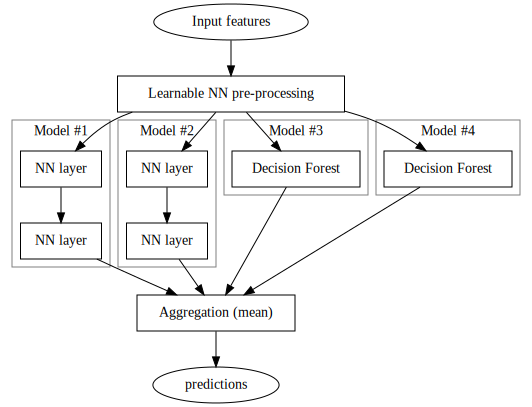

In [2]:
#@title

!pip install graphviz -U --quiet

from graphviz import Source

Source("""
digraph G {
  raw_data [label="Input features"];
  preprocess_data [label="Learnable NN pre-processing", shape=rect];

  raw_data -> preprocess_data

  subgraph cluster_0 {
    color=grey;
    a1[label="NN layer", shape=rect];
    b1[label="NN layer", shape=rect];
    a1 -> b1;
	label = "Model #1";
  }

   subgraph cluster_1 {
    color=grey;
    a2[label="NN layer", shape=rect];
    b2[label="NN layer", shape=rect];
    a2 -> b2;
	label = "Model #2";
  }

  subgraph cluster_2 {
    color=grey;
    a3[label="Decision Forest", shape=rect];
	label = "Model #3";
  }

  subgraph cluster_3 {
    color=grey;
    a4[label="Decision Forest", shape=rect];
	label = "Model #4";
  }

  preprocess_data -> a1;
  preprocess_data -> a2;
  preprocess_data -> a3;
  preprocess_data -> a4;

  b1  -> aggr;
  b2  -> aggr;
  a3 -> aggr;
  a4 -> aggr;

  aggr [label="Aggregation (mean)", shape=rect]
  aggr -> predictions
}
""")

Your composed model has three stages:

1.  The first stage is a preprocessing layer composed of a neural network and
    common to all the models in the next stage. In practice, such a
    preprocessing layer could either be a pre-trained embedding to fine-tune, or
    a randomly initialized neural network.
2.  The second stage is an ensemble of two decision forest and two neural
    network models.
3.  The last stage averages the predictions of the models in the second stage.
    It does not contain any learnable weights.

The neural networks are trained using the
[backpropagation algorithm](https://developers.google.com/machine-learning/glossary#backpropagation)
and gradient descent. This algorithm has two important properties: (1) The layer
of neural network can be trained if its receives a loss gradient (more
precisely, the gradient of the loss according to the layer's output), and (2)
the algorithm "transmits" the loss gradient from the layer's output to the
layer's input (this is the "chain rule"). For these two reasons, Backpropagation
can train together multiple layers of neural networks stacked on top of each
other.

In this example, the decision forests are trained with the
[Random Forest](https://developers.google.com/machine-learning/glossary#random-forest)
(RF) algorithm. Unlike Backpropagation, the training of RF does not "transmit"
the loss gradient to from its output to its input. For this reasons, the
classical RF algorithm cannot be used to train or fine-tune a neural network
underneath. In other words, the "decision forest" stages cannot be used to train
the "Learnable NN pre-processing block".

1.  Train the preprocessing and neural networks stage.
2.  Train the decision forest stages.

## Install TensorFlow Decision Forests

Install TF-DF by running the following cell.

In [3]:
!pip install tensorflow_decision_forests -U --quiet


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display
the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [4]:
!pip install wurlitzer -U --quiet

## Import libraries

In [5]:
import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow_decision_forests as tfdf

import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras
import math
import matplotlib.pyplot as plt

## Dataset

You will use a simple synthetic dataset in this tutorial to make it easier to
interpret the final model.

In [6]:
def make_dataset(num_examples, num_features, seed=1234):
  np.random.seed(seed)
  features = np.random.uniform(-1, 1, size=(num_examples, num_features))
  noise = np.random.uniform(size=(num_examples))

  left_side = np.sqrt(
      np.sum(np.multiply(np.square(features[:, 0:2]), [1, 2]), axis=1))
  right_side = features[:, 2] * 0.7 + np.sin(
      features[:, 3] * 10) * 0.5 + noise * 0.0 + 0.5

  labels = left_side <= right_side
  return features, labels.astype(int)

Generate some examples:

In [7]:
make_dataset(num_examples=5, num_features=4)

(array([[-0.6169611 ,  0.24421754, -0.12454452,  0.57071717],
        [ 0.55995162, -0.45481479, -0.44707149,  0.60374436],
        [ 0.91627871,  0.75186527, -0.28436546,  0.00199025],
        [ 0.36692587,  0.42540405, -0.25949849,  0.12239237],
        [ 0.00616633, -0.9724631 ,  0.54565324,  0.76528238]]),
 array([0, 0, 0, 1, 0]))

You can also plot them to get an idea of the synthetic pattern:

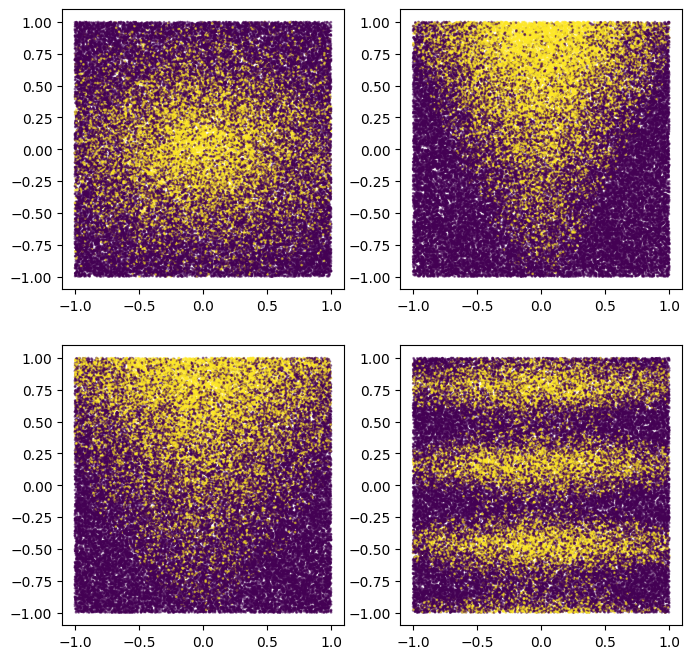

In [8]:
plot_features, plot_label = make_dataset(num_examples=50000, num_features=4)

plt.rcParams["figure.figsize"] = [8, 8]
common_args = dict(c=plot_label, s=1.0, alpha=0.5)

plt.subplot(2, 2, 1)
plt.scatter(plot_features[:, 0], plot_features[:, 1], **common_args)

plt.subplot(2, 2, 2)
plt.scatter(plot_features[:, 1], plot_features[:, 2], **common_args)

plt.subplot(2, 2, 3)
plt.scatter(plot_features[:, 0], plot_features[:, 2], **common_args)

plt.subplot(2, 2, 4)
plt.scatter(plot_features[:, 0], plot_features[:, 3], **common_args)

Note that this pattern is smooth and not axis aligned. This will advantage the neural network models. This is because it is easier for a neural network than for a decision tree to have round and non aligned decision boundaries.

On the other hand, we will train the model on a small datasets with 2500 examples. This will advantage the decision forest models. This is because decision forests are much more efficient, using all the available information from the examples (decision forests are "sample efficient").

Our ensemble of neural networks and decision forests will use the best of both worlds.

Let's create a train and test `tf.data.Dataset`:

In [9]:
def make_tf_dataset(batch_size=64, **args):
  features, labels = make_dataset(**args)
  return tf.data.Dataset.from_tensor_slices(
      (features, labels)).batch(batch_size)


num_features = 10

train_dataset = make_tf_dataset(
    num_examples=2500, num_features=num_features, batch_size=100, seed=1234)
test_dataset = make_tf_dataset(
    num_examples=10000, num_features=num_features, batch_size=100, seed=5678)

## Model structure

Define the model structure as follows:

In [10]:
# Input features.
raw_features = tf_keras.layers.Input(shape=(num_features,))

# Stage 1
# =======

# Common learnable pre-processing
preprocessor = tf_keras.layers.Dense(10, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)

# Stage 2
# =======

# Model #1: NN
m1_z1 = tf_keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m1_pred = tf_keras.layers.Dense(1, activation=tf.nn.sigmoid)(m1_z1)

# Model #2: NN
m2_z1 = tf_keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m2_pred = tf_keras.layers.Dense(1, activation=tf.nn.sigmoid)(m2_z1)


# Model #3: DF
model_3 = tfdf.keras.RandomForestModel(num_trees=1000, random_seed=1234)
m3_pred = model_3(preprocess_features)

# Model #4: DF
model_4 = tfdf.keras.RandomForestModel(
    num_trees=1000,
    #split_axis="SPARSE_OBLIQUE", # Uncomment this line to increase the quality of this model
    random_seed=4567)
m4_pred = model_4(preprocess_features)

# Since TF-DF uses deterministic learning algorithms, you should set the model's
# training seed to different values otherwise both
# `tfdf.keras.RandomForestModel` will be exactly the same.

# Stage 3
# =======

mean_nn_only = tf.reduce_mean(tf.stack([m1_pred, m2_pred], axis=0), axis=0)
mean_nn_and_df = tf.reduce_mean(
    tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)

# Keras Models
# ============

ensemble_nn_only = tf_keras.models.Model(raw_features, mean_nn_only)
ensemble_nn_and_df = tf_keras.models.Model(raw_features, mean_nn_and_df)

Use /tmpfs/tmp/tmp5rudwfpk as temporary training directory


Use /tmpfs/tmp/tmp7z3k5oog as temporary training directory


Before you train the model, you can plot it to check if it is similar to the
initial diagram.

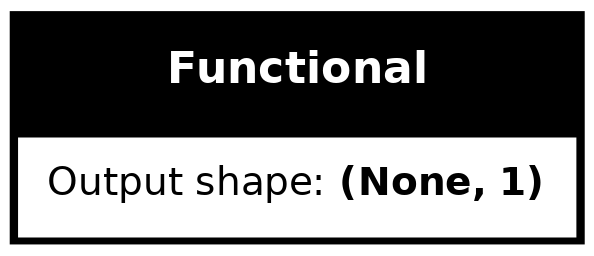

In [11]:
from keras.utils import plot_model

plot_model(ensemble_nn_and_df, to_file="/tmp/model.png", show_shapes=True)

## Model training

First train the preprocessing and two neural network layers using the
backpropagation algorithm.

In [12]:
%%time
ensemble_nn_only.compile(
        optimizer=tf_keras.optimizers.Adam(),
        loss=tf_keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])

ensemble_nn_only.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20


I0000 00:00:1713611529.601020   11701 service.cc:145] XLA service 0x7f48904d48d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713611529.601060   11701 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1713611529.601064   11701 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1713611529.601067   11701 service.cc:153]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1713611529.601069   11701 service.cc:153]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5
I0000 00:00:1713611529.771938   11701 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/25 [>.............................] - ETA: 5:31 - loss: 0.6169 - accuracy: 0.7200

17/25 [===================>..........] - ETA: 0s - loss: 0.5802 - accuracy: 0.7529  

25/25 [==============================] - 15s 33ms/step - loss: 0.5756 - accuracy: 0.7500 - val_loss: 0.5714 - val_accuracy: 0.7392


Epoch 2/20


 1/25 [>.............................] - ETA: 0s - loss: 0.5960 - accuracy: 0.7200

17/25 [===================>..........] - ETA: 0s - loss: 0.5558 - accuracy: 0.7529

25/25 [==============================] - 0s 11ms/step - loss: 0.5524 - accuracy: 0.7500 - val_loss: 0.5543 - val_accuracy: 0.7392


Epoch 3/20


 1/25 [>.............................] - ETA: 0s - loss: 0.5810 - accuracy: 0.7200

17/25 [===================>..........] - ETA: 0s - loss: 0.5382 - accuracy: 0.7529

25/25 [==============================] - 0s 10ms/step - loss: 0.5351 - accuracy: 0.7500 - val_loss: 0.5406 - val_accuracy: 0.7392


Epoch 4/20


 1/25 [>.............................] - ETA: 0s - loss: 0.5676 - accuracy: 0.7200

17/25 [===================>..........] - ETA: 0s - loss: 0.5241 - accuracy: 0.7529

25/25 [==============================] - 0s 10ms/step - loss: 0.5209 - accuracy: 0.7500 - val_loss: 0.5287 - val_accuracy: 0.7392


Epoch 5/20


 1/25 [>.............................] - ETA: 0s - loss: 0.5541 - accuracy: 0.7200

17/25 [===================>..........] - ETA: 0s - loss: 0.5120 - accuracy: 0.7529

25/25 [==============================] - 0s 10ms/step - loss: 0.5083 - accuracy: 0.7500 - val_loss: 0.5176 - val_accuracy: 0.7392


Epoch 6/20


 1/25 [>.............................] - ETA: 0s - loss: 0.5398 - accuracy: 0.7200

18/25 [====================>.........] - ETA: 0s - loss: 0.4962 - accuracy: 0.7556

25/25 [==============================] - 0s 10ms/step - loss: 0.4967 - accuracy: 0.7500 - val_loss: 0.5072 - val_accuracy: 0.7392


Epoch 7/20


 1/25 [>.............................] - ETA: 0s - loss: 0.5245 - accuracy: 0.7200

18/25 [====================>.........] - ETA: 0s - loss: 0.4857 - accuracy: 0.7561

25/25 [==============================] - 0s 10ms/step - loss: 0.4856 - accuracy: 0.7512 - val_loss: 0.4973 - val_accuracy: 0.7397


Epoch 8/20


 1/25 [>.............................] - ETA: 0s - loss: 0.5085 - accuracy: 0.7300

18/25 [====================>.........] - ETA: 0s - loss: 0.4759 - accuracy: 0.7572

25/25 [==============================] - 0s 10ms/step - loss: 0.4753 - accuracy: 0.7524 - val_loss: 0.4882 - val_accuracy: 0.7421


Epoch 9/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4926 - accuracy: 0.7300

17/25 [===================>..........] - ETA: 0s - loss: 0.4717 - accuracy: 0.7582

25/25 [==============================] - 0s 10ms/step - loss: 0.4658 - accuracy: 0.7572 - val_loss: 0.4799 - val_accuracy: 0.7454


Epoch 10/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4772 - accuracy: 0.7400

18/25 [====================>.........] - ETA: 0s - loss: 0.4589 - accuracy: 0.7617

25/25 [==============================] - 0s 10ms/step - loss: 0.4572 - accuracy: 0.7600 - val_loss: 0.4726 - val_accuracy: 0.7500


Epoch 11/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4628 - accuracy: 0.7500

18/25 [====================>.........] - ETA: 0s - loss: 0.4520 - accuracy: 0.7689

25/25 [==============================] - 0s 10ms/step - loss: 0.4498 - accuracy: 0.7668 - val_loss: 0.4664 - val_accuracy: 0.7575


Epoch 12/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4499 - accuracy: 0.7400

18/25 [====================>.........] - ETA: 0s - loss: 0.4460 - accuracy: 0.7778

25/25 [==============================] - 0s 10ms/step - loss: 0.4435 - accuracy: 0.7748 - val_loss: 0.4612 - val_accuracy: 0.7637


Epoch 13/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4386 - accuracy: 0.7300

17/25 [===================>..........] - ETA: 0s - loss: 0.4458 - accuracy: 0.7771

25/25 [==============================] - 0s 11ms/step - loss: 0.4382 - accuracy: 0.7780 - val_loss: 0.4569 - val_accuracy: 0.7678


Epoch 14/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4287 - accuracy: 0.7400

17/25 [===================>..........] - ETA: 0s - loss: 0.4419 - accuracy: 0.7794

25/25 [==============================] - 0s 10ms/step - loss: 0.4339 - accuracy: 0.7832 - val_loss: 0.4534 - val_accuracy: 0.7702


Epoch 15/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4203 - accuracy: 0.7400

17/25 [===================>..........] - ETA: 0s - loss: 0.4384 - accuracy: 0.7841

25/25 [==============================] - 0s 11ms/step - loss: 0.4302 - accuracy: 0.7888 - val_loss: 0.4504 - val_accuracy: 0.7731


Epoch 16/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4129 - accuracy: 0.7700

17/25 [===================>..........] - ETA: 0s - loss: 0.4354 - accuracy: 0.7865

25/25 [==============================] - 0s 10ms/step - loss: 0.4269 - accuracy: 0.7920 - val_loss: 0.4477 - val_accuracy: 0.7768


Epoch 17/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4059 - accuracy: 0.7700

18/25 [====================>.........] - ETA: 0s - loss: 0.4280 - accuracy: 0.7878

25/25 [==============================] - 0s 10ms/step - loss: 0.4239 - accuracy: 0.7924 - val_loss: 0.4452 - val_accuracy: 0.7786


Epoch 18/20


 1/25 [>.............................] - ETA: 0s - loss: 0.4001 - accuracy: 0.7900

18/25 [====================>.........] - ETA: 0s - loss: 0.4254 - accuracy: 0.7911

25/25 [==============================] - 0s 10ms/step - loss: 0.4211 - accuracy: 0.7936 - val_loss: 0.4429 - val_accuracy: 0.7800


Epoch 19/20


 1/25 [>.............................] - ETA: 0s - loss: 0.3952 - accuracy: 0.8000

18/25 [====================>.........] - ETA: 0s - loss: 0.4228 - accuracy: 0.7961

25/25 [==============================] - 0s 10ms/step - loss: 0.4184 - accuracy: 0.7976 - val_loss: 0.4406 - val_accuracy: 0.7819


Epoch 20/20


 1/25 [>.............................] - ETA: 0s - loss: 0.3908 - accuracy: 0.8100

18/25 [====================>.........] - ETA: 0s - loss: 0.4202 - accuracy: 0.7983

25/25 [==============================] - 0s 10ms/step - loss: 0.4158 - accuracy: 0.7992 - val_loss: 0.4382 - val_accuracy: 0.7836


CPU times: user 20.7 s, sys: 1.36 s, total: 22 s
Wall time: 19.6 s


Let's evaluate the preprocessing and the part with the two neural networks only:

In [13]:
evaluation_nn_only = ensemble_nn_only.evaluate(test_dataset, return_dict=True)
print("Accuracy (NN #1 and #2 only): ", evaluation_nn_only["accuracy"])
print("Loss (NN #1 and #2 only): ", evaluation_nn_only["loss"])

  1/100 [..............................] - ETA: 0s - loss: 0.3786 - accuracy: 0.8300

 27/100 [=======>......................] - ETA: 0s - loss: 0.4354 - accuracy: 0.7896

 53/100 [==============>...............] - ETA: 0s - loss: 0.4311 - accuracy: 0.7915

 78/100 [======================>.......] - ETA: 0s - loss: 0.4339 - accuracy: 0.7891

100/100 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.7836


Accuracy (NN #1 and #2 only):  0.7835999727249146
Loss (NN #1 and #2 only):  0.438231498003006


Let's train the two Decision Forest components (one after another).

In [14]:
%%time
train_dataset_with_preprocessing = train_dataset.map(lambda x,y: (preprocessor(x), y))
test_dataset_with_preprocessing = test_dataset.map(lambda x,y: (preprocessor(x), y))

model_3.fit(train_dataset_with_preprocessing)
model_4.fit(train_dataset_with_preprocessing)

Cause: could not parse the source code of <function <lambda> at 0x7f4b7b5d91f0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f4b7b5d91f0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f4b7b5d91f0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f4b7ba3eee0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f4b7ba3eee0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f4b7ba3eee0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Reading training dataset...


Training dataset read in 0:00:03.699343. Found 2500 examples.


Training model...


[INFO 24-04-20 11:12:20.9165 UTC kernel.cc:1233] Loading model from path /tmpfs/tmp/tmp5rudwfpk/model/ with prefix 3da3a8649d9e4cb4


Model trained in 0:00:02.061496


Compiling model...


[INFO 24-04-20 11:12:22.0091 UTC decision_forest.cc:734] Model loaded with 1000 root(s), 355690 node(s), and 10 input feature(s).
[INFO 24-04-20 11:12:22.0091 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-20 11:12:22.0091 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


Reading training dataset...


Training dataset read in 0:00:00.231041. Found 2500 examples.


Training model...


[INFO 24-04-20 11:12:23.7301 UTC kernel.cc:1233] Loading model from path /tmpfs/tmp/tmp7z3k5oog/model/ with prefix 8b0da5e131c043b2


Model trained in 0:00:01.916593


Compiling model...


[INFO 24-04-20 11:12:24.7575 UTC decision_forest.cc:734] Model loaded with 1000 root(s), 357028 node(s), and 10 input feature(s).
[INFO 24-04-20 11:12:24.7576 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


CPU times: user 22.9 s, sys: 1.73 s, total: 24.6 s
Wall time: 8.74 s


And let's evaluate the Decision Forests individually.

In [15]:
model_3.compile(["accuracy"])
model_4.compile(["accuracy"])

evaluation_df3_only = model_3.evaluate(
    test_dataset_with_preprocessing, return_dict=True)
evaluation_df4_only = model_4.evaluate(
    test_dataset_with_preprocessing, return_dict=True)

print("Accuracy (DF #3 only): ", evaluation_df3_only["accuracy"])
print("Accuracy (DF #4 only): ", evaluation_df4_only["accuracy"])

  1/100 [..............................] - ETA: 50s - loss: 0.0000e+00 - accuracy: 0.9000

  6/100 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8067 

 11/100 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8118

 17/100 [====>.........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8124

 23/100 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8104

 29/100 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8031

 35/100 [=========>....................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8040

 40/100 [===========>..................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8048

 45/100 [============>.................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8062

 51/100 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8049

 57/100 [================>.............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8054

 62/100 [=================>............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8034

 67/100 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8028

 73/100 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8025

 79/100 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8016

 84/100 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8005

 89/100 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8003

 94/100 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7993

100/100 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7990

100/100 [==============================] - 2s 10ms/step - loss: 0.0000e+00 - accuracy: 0.7990


  1/100 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 0.9000

  6/100 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8100 

 11/100 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8155

 16/100 [===>..........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8188

 21/100 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8133

 27/100 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8081

 32/100 [========>.....................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8047

 38/100 [==========>...................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8066

 43/100 [===========>..................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8086

 49/100 [=============>................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8043

 55/100 [===============>..............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8064

 60/100 [=================>............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8053

 65/100 [==================>...........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8052

 70/100 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8049

 75/100 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8052

 81/100 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8017

 86/100 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8019

 91/100 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7997

 96/100 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7997

100/100 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.7989


Accuracy (DF #3 only):  0.7990000247955322
Accuracy (DF #4 only):  0.7989000082015991


Let's evaluate the entire model composition:

In [16]:
ensemble_nn_and_df.compile(
    loss=tf_keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

evaluation_nn_and_df = ensemble_nn_and_df.evaluate(
    test_dataset, return_dict=True)

print("Accuracy (2xNN and 2xDF): ", evaluation_nn_and_df["accuracy"])
print("Loss (2xNN and 2xDF): ", evaluation_nn_and_df["loss"])

  1/100 [..............................] - ETA: 1:18 - loss: 0.3363 - accuracy: 0.8500

  6/100 [>.............................] - ETA: 0s - loss: 0.4364 - accuracy: 0.8017  

 11/100 [==>...........................] - ETA: 0s - loss: 0.4209 - accuracy: 0.8055

 17/100 [====>.........................] - ETA: 0s - loss: 0.4093 - accuracy: 0.8106

 23/100 [=====>........................] - ETA: 0s - loss: 0.4152 - accuracy: 0.8070

 29/100 [=======>......................] - ETA: 0s - loss: 0.4204 - accuracy: 0.8017

 34/100 [=========>....................] - ETA: 0s - loss: 0.4165 - accuracy: 0.8068

 39/100 [==========>...................] - ETA: 0s - loss: 0.4146 - accuracy: 0.8062

 44/100 [============>.................] - ETA: 0s - loss: 0.4165 - accuracy: 0.8061

 49/100 [=============>................] - ETA: 0s - loss: 0.4209 - accuracy: 0.8020

 55/100 [===============>..............] - ETA: 0s - loss: 0.4151 - accuracy: 0.8051

 60/100 [=================>............] - ETA: 0s - loss: 0.4169 - accuracy: 0.8033

 65/100 [==================>...........] - ETA: 0s - loss: 0.4199 - accuracy: 0.8031

 70/100 [====================>.........] - ETA: 0s - loss: 0.4186 - accuracy: 0.8023

 75/100 [=====================>........] - ETA: 0s - loss: 0.4177 - accuracy: 0.8020

 80/100 [=======================>......] - ETA: 0s - loss: 0.4209 - accuracy: 0.7987

 85/100 [========================>.....] - ETA: 0s - loss: 0.4199 - accuracy: 0.7984

 91/100 [==========================>...] - ETA: 0s - loss: 0.4210 - accuracy: 0.7964

 96/100 [===========================>..] - ETA: 0s - loss: 0.4217 - accuracy: 0.7962

100/100 [==============================] - 2s 10ms/step - loss: 0.4226 - accuracy: 0.7953


Accuracy (2xNN and 2xDF):  0.7953000068664551
Loss (2xNN and 2xDF):  0.4225609302520752


To finish, let's finetune the neural network layer a bit more. Note that we do
not finetune the pre-trained embedding as the DF models depends on it (unless we
would also retrain them after).

In summary, you have:

In [17]:
#@title

print(f"Accuracy (NN #1 and #2 only):\t{evaluation_nn_only['accuracy']:.6f}")
print(f"Accuracy (DF #3 only):\t\t{evaluation_df3_only['accuracy']:.6f}")
print(f"Accuracy (DF #4 only):\t\t{evaluation_df4_only['accuracy']:.6f}")
print("----------------------------------------")
print(f"Accuracy (2xNN and 2xDF):\t{evaluation_nn_and_df['accuracy']:.6f}")


def delta_percent(src_eval, key):
  src_acc = src_eval["accuracy"]
  final_acc = evaluation_nn_and_df["accuracy"]
  increase = final_acc - src_acc
  print(f"\t\t\t\t  {increase:+.6f} over {key}")


delta_percent(evaluation_nn_only, "NN #1 and #2 only")
delta_percent(evaluation_df3_only, "DF #3 only")
delta_percent(evaluation_df4_only, "DF #4 only")

Accuracy (NN #1 and #2 only):	0.783600
Accuracy (DF #3 only):		0.799000
Accuracy (DF #4 only):		0.798900
----------------------------------------
Accuracy (2xNN and 2xDF):	0.795300
				  +0.011700 over NN #1 and #2 only
				  -0.003700 over DF #3 only
				  -0.003600 over DF #4 only


Here, you can see that the composed model performs better than its individual
parts. This is why ensembles work so well.

## What's next?

In this example, you saw how to combine decision forests with neural networks.
An extra step would be to further train the neural network and the decision
forests together.

In addition, for the sake of clarity, the decision forests received only the
preprocessed input. However, decision forests are generally great are consuming
raw data. The model would be improved by also feeding the raw features to the
decision forest models.

In this example, the final model is the average of the predictions of the
individual models. This solution works well if all of the model perform more of
less with the same. However, if one of the sub-models is very good, aggregating
it with other models might actually be detrimental (or vice-versa; for example
try to reduce the number of examples from 1k and see how it hurts the neural
networks a lot; or enable the `SPARSE_OBLIQUE` split in the second Random Forest
model).